# Task 6 · Time-Series Decomposition & Typical Profiles

This notebook performs seasonal-trend decomposition of the household demand series, quantifies seasonality strength across multiple horizons, and derives typical demand profiles for reporting and dashboard integration.

In [1]:
from pathlib import Path
import sys
import calendar

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.tsa.seasonal import STL
from IPython.display import display

# Ensure project modules are discoverable regardless of notebook launch directory
ROOT = Path.cwd().resolve()
if not (ROOT / 'src').exists():
    ROOT = ROOT.parent
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

from src.plotting import (
    plot_stl_components,
    plot_typical_profiles_weekday_weekend,
    plot_typical_profiles_monthly,
)

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl

pd.options.display.max_rows = 12

FIG_PATH = ROOT / "reports" / "figures"
TABLE_PATH = ROOT / "reports" / "tables"
DATA_PATH = ROOT / "data" / "raw" / "train_252145.csv"

FIG_PATH.mkdir(parents=True, exist_ok=True)
TABLE_PATH.mkdir(parents=True, exist_ok=True)

# Matplotlib styling for academic figures
mpl.rcParams.update({
    'figure.dpi': 120,
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'axes.edgecolor': 'black',
    'axes.labelcolor': 'black',
    'axes.titleweight': 'semibold',
    'axes.grid': True,
    'grid.color': '#d9d9d9',
    'grid.linestyle': '--',
    'grid.linewidth': 0.6,
    'font.family': 'DejaVu Sans',
    'legend.frameon': True,
    'legend.framealpha': 0.9,
})

COLORS = {
    'observed': '#1f77b4',
    'trend': '#2ca02c',
    'seasonal': '#FFA500',
    'residual': '#d62728',
    'weekday': '#1f77b4',
    'weekend': '#F45B69',
}


def save_figure(fig, basename, dpi=300):
    """Save matplotlib figure as PNG only."""
    png_path = FIG_PATH / f'{basename}.png'
    fig.savefig(png_path, dpi=dpi, bbox_inches='tight')
    print(f"Saved: {png_path}")
    return png_path


df = pd.read_csv(DATA_PATH, parse_dates=["timestamp"]).sort_values("timestamp")
df["Demand"] = pd.to_numeric(df["Demand"], errors="coerce")
df = df.set_index("timestamp").sort_index()
df = df[~df.index.duplicated(keep="first")]

# Aggregate to hourly cadence and interpolate small gaps for decomposition
hourly_demand = df["Demand"].resample("H").mean()
interpolated_points = hourly_demand.isna().sum()
hourly_demand = hourly_demand.interpolate(method="time", limit_direction="both")
hourly_demand = hourly_demand.dropna()

print(
    f"Hourly demand: {hourly_demand.index.min()} → {hourly_demand.index.max()} | "
    f"Observations: {len(hourly_demand):,} | Interpolated gaps: {interpolated_points}"
)

Hourly demand: 2013-07-01 00:00:00+00:00 → 2014-06-30 23:00:00+00:00 | Observations: 8,760 | Interpolated gaps: 1


In [3]:
def run_stl(series: pd.Series, period: int, seasonal: int | None = None) -> tuple[STL, pd.DataFrame]:
    seasonal_kw = {} if seasonal is None else {"seasonal": seasonal}
    stl = STL(series, period=period, robust=True, **seasonal_kw)
    result = stl.fit()
    components = pd.DataFrame(
        {
            "trend": result.trend,
            "seasonal": result.seasonal,
            "resid": result.resid,
        },
        index=series.index,
    )
    return result, components


# Daily (intraday) decomposition on hourly series
stl_daily_result, stl_daily_components = run_stl(hourly_demand, period=24)

# Weekly and annual decomposition on daily-averaged demand for stability

daily_avg_demand = hourly_demand.resample("D").mean()
stl_weekly_result, stl_weekly_components = run_stl(daily_avg_demand, period=7)
stl_annual_result, stl_annual_components = run_stl(daily_avg_demand, period=365, seasonal=31)

print("Daily STL Components (Head):")
display(stl_daily_components.head())

Daily STL Components (Head):


,trend,seasonal,resid
timestamp,,,
2013-07-01 00:00:00+00:00,0.510776,-0.244343,0.003567
2013-07-01 01:00:00+00:00,0.509786,-0.293644,0.013858
2013-07-01 02:00:00+00:00,0.508822,-0.268554,0.019732
2013-07-01 03:00:00+00:00,0.507883,-0.252718,0.024835
2013-07-01 04:00:00+00:00,0.506970,-0.249343,0.032373


In [4]:
def seasonality_strength(residual: pd.Series, component: pd.Series) -> float:
    resid_var = float(np.nanvar(residual))
    combined_var = float(np.nanvar(residual + component))
    if np.isclose(combined_var, 0.0):
        return np.nan
    strength = 1.0 - resid_var / combined_var
    return float(np.clip(strength, 0.0, 1.0))


strength_records = [
    {"period": "24h", "strength_type": "Seasonal", "value": seasonality_strength(stl_daily_result.resid, stl_daily_result.seasonal)},
    {"period": "24h", "strength_type": "Trend", "value": seasonality_strength(stl_daily_result.resid, stl_daily_result.trend)},
    {"period": "7d", "strength_type": "Seasonal", "value": seasonality_strength(stl_weekly_result.resid, stl_weekly_result.seasonal)},
    {"period": "7d", "strength_type": "Trend", "value": seasonality_strength(stl_weekly_result.resid, stl_weekly_result.trend)},
    {"period": "365d", "strength_type": "Seasonal", "value": seasonality_strength(stl_annual_result.resid, stl_annual_result.seasonal)},
    {"period": "365d", "strength_type": "Trend", "value": seasonality_strength(stl_annual_result.resid, stl_annual_result.trend)},
]

seasonality_strength_df = pd.DataFrame(strength_records).dropna()
seasonality_strength_df["value"] = seasonality_strength_df["value"].round(3)
seasonality_strength_df.to_csv(TABLE_PATH / "seasonality_strength.csv", index=False)

print("Seasonality Strength:")
display(seasonality_strength_df)

Seasonality Strength:


,period,strength_type,value
0,24h,Seasonal,0.242
1,24h,Trend,0.107
2,7d,Seasonal,0.221
3,7d,Trend,0.448
4,365d,Seasonal,1.000


Saved: /Users/samuel/EDS/Energy_Data_Science/reports/figures/06_stl_decomposition.png


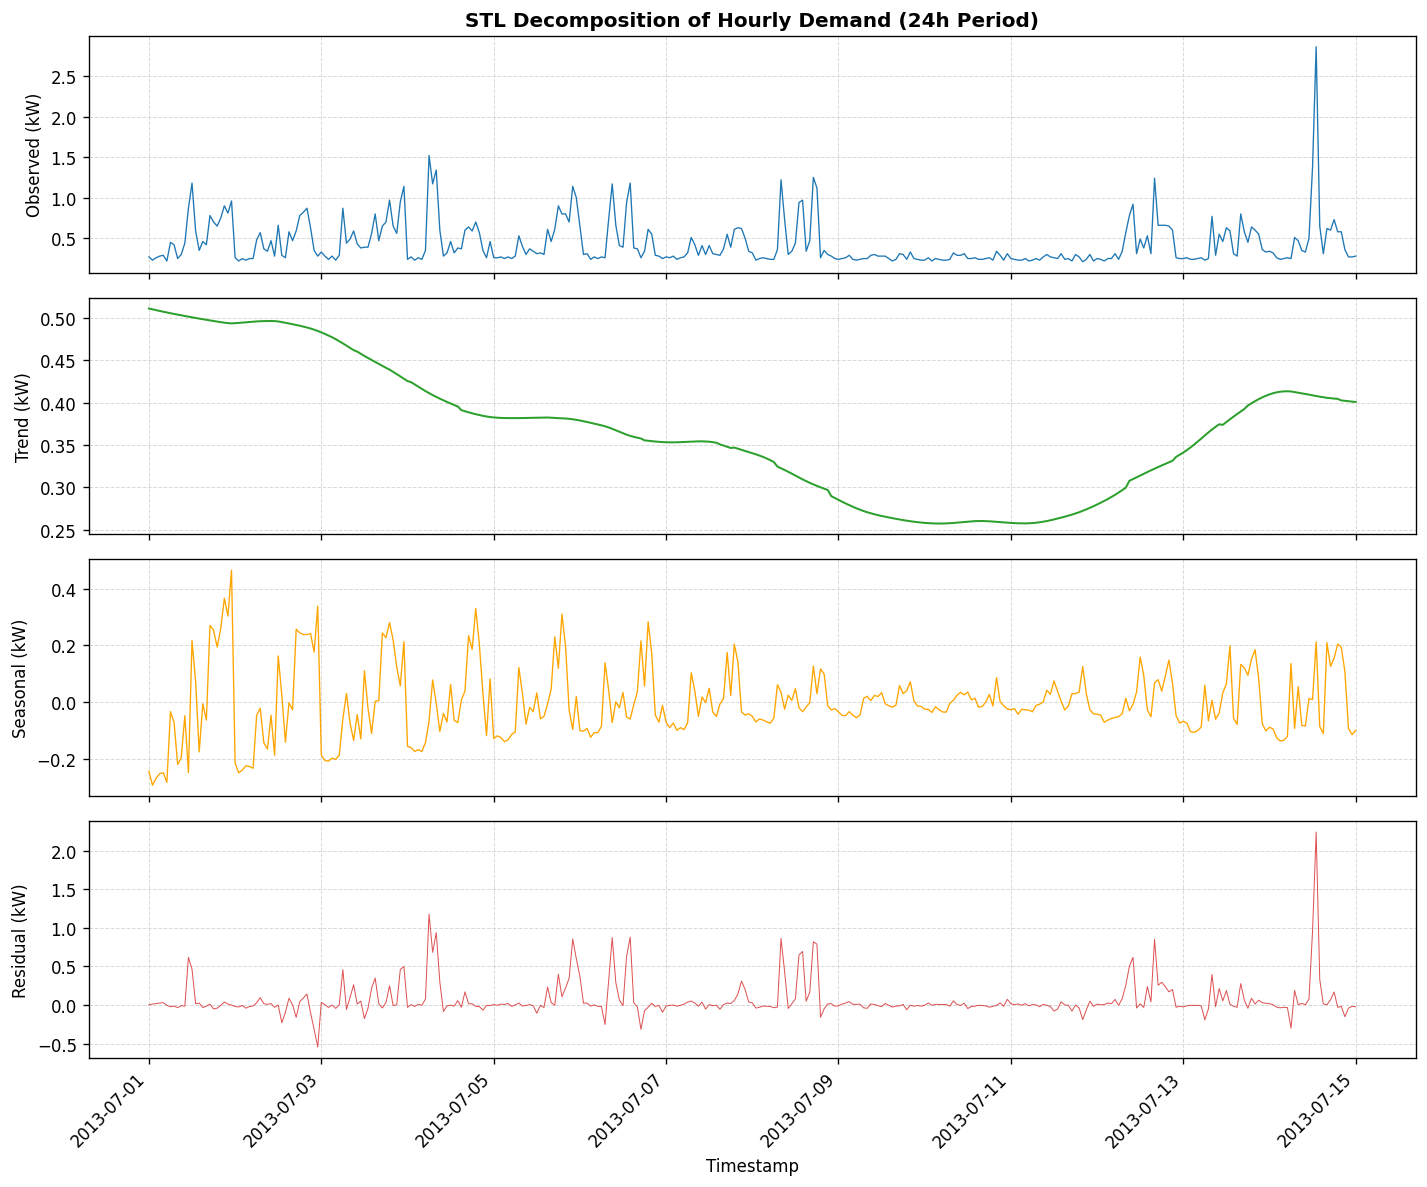

In [6]:
# Figure 1: STL Decomposition Components
# Visualize the additive decomposition: Observed = Trend + Seasonal + Residual
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

# Plot a subset for readability (first 2 weeks from start of data)
start_date = stl_daily_components.index.min()
end_date = start_date + pd.Timedelta(days=14)
plot_range = slice(start_date, end_date)

plot_data = stl_daily_components.loc[plot_range]
observed = hourly_demand.loc[plot_range]

axes[0].plot(observed.index, observed.values, color=COLORS['observed'], linewidth=0.8)
axes[0].set_ylabel('Observed (kW)')
axes[0].set_title('STL Decomposition of Hourly Demand (24h Period)')

axes[1].plot(plot_data.index, plot_data['trend'], color=COLORS['trend'], linewidth=1.2)
axes[1].set_ylabel('Trend (kW)')

axes[2].plot(plot_data.index, plot_data['seasonal'], color=COLORS['seasonal'], linewidth=0.8)
axes[2].set_ylabel('Seasonal (kW)')

axes[3].plot(plot_data.index, plot_data['resid'], color=COLORS['residual'], linewidth=0.6, alpha=0.8)
axes[3].set_ylabel('Residual (kW)')
axes[3].set_xlabel('Timestamp')

# Rotate x-axis labels for better readability
for ax in axes:
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

fig.tight_layout()
save_figure(fig, '06_stl_decomposition')
plt.show()

Saved: /Users/samuel/EDS/Energy_Data_Science/reports/figures/06_seasonality_strength.png


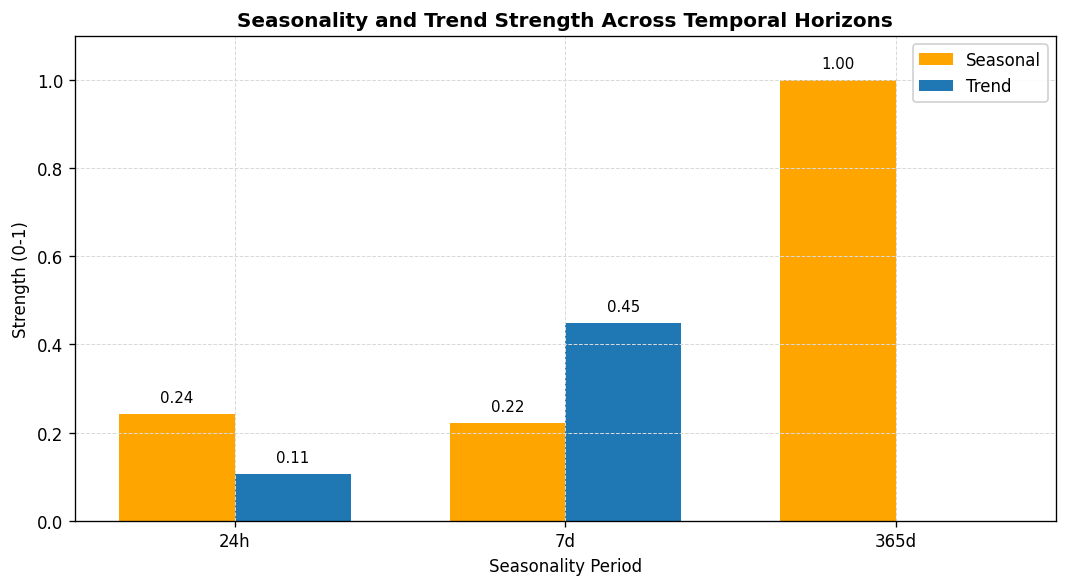

In [8]:
# Figure 2: Seasonality Strength across different periods
# Bar chart showing the strength of seasonal and trend components
fig, ax = plt.subplots(figsize=(9, 5))

# Pivot the data for easier plotting
strength_pivot = seasonality_strength_df.pivot(index='period', columns='strength_type', values='value')
strength_pivot = strength_pivot.reindex(['24h', '7d', '365d'])  # Ensure correct order

# Fill NaN values with 0 for plotting
strength_pivot = strength_pivot.fillna(0)

x = np.arange(len(strength_pivot))
width = 0.35

bars1 = ax.bar(x - width/2, strength_pivot['Seasonal'], width, label='Seasonal', color=COLORS['seasonal'])
bars2 = ax.bar(x + width/2, strength_pivot['Trend'], width, label='Trend', color=COLORS['observed'])

ax.set_xlabel('Seasonality Period')
ax.set_ylabel('Strength (0-1)')
ax.set_title('Seasonality and Trend Strength Across Temporal Horizons')
ax.set_xticks(x)
ax.set_xticklabels(strength_pivot.index)
ax.set_ylim(0, 1.1)
ax.legend()

# Add value labels on bars
for bar in bars1:
    if bar.get_height() > 0:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                f'{bar.get_height():.2f}', ha='center', va='bottom', fontsize=9)
for bar in bars2:
    if bar.get_height() > 0:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                f'{bar.get_height():.2f}', ha='center', va='bottom', fontsize=9)

fig.tight_layout()
save_figure(fig, '06_seasonality_strength')
plt.show()

Saved: /Users/samuel/EDS/Energy_Data_Science/reports/figures/06_typical_profiles_weekday_weekend.png


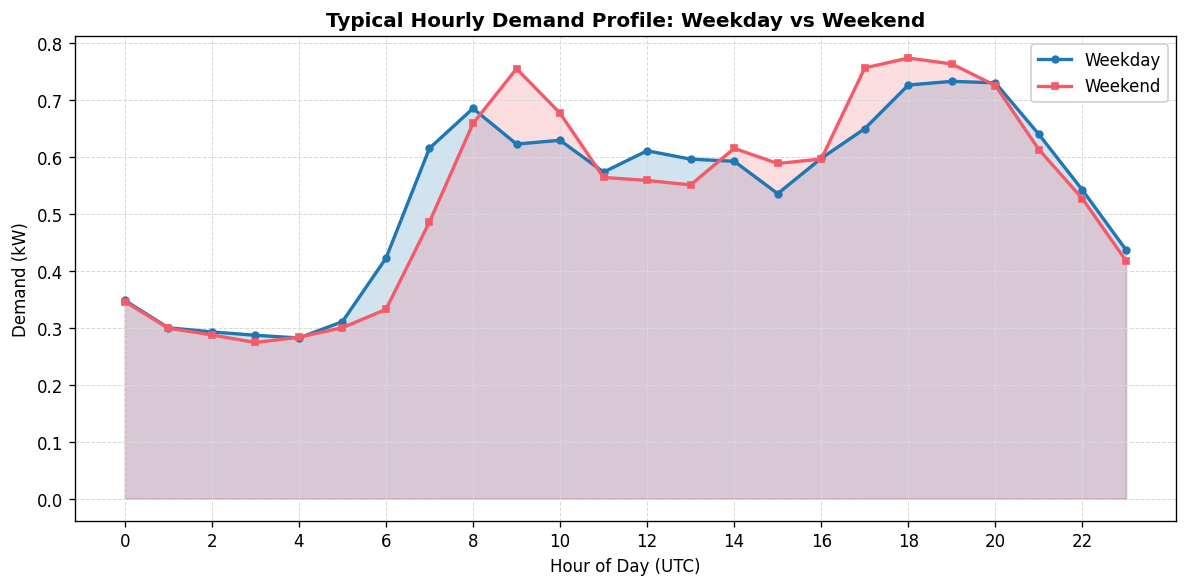

In [9]:
# Figure 3: Typical Hourly Profiles - Weekday vs Weekend
# Aggregated demand profiles showing behavioral differences
profiles_df = hourly_demand.to_frame(name="Demand")
profiles_df["hour"] = profiles_df.index.hour
profiles_df["is_weekend"] = profiles_df.index.dayofweek >= 5

weekday_profile = profiles_df.loc[~profiles_df["is_weekend"]].groupby("hour")["Demand"].mean()
weekend_profile = profiles_df.loc[profiles_df["is_weekend"]].groupby("hour")["Demand"].mean()

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(weekday_profile.index, weekday_profile.values, color=COLORS['weekday'], 
        linewidth=2, marker='o', markersize=4, label='Weekday')
ax.plot(weekend_profile.index, weekend_profile.values, color=COLORS['weekend'], 
        linewidth=2, marker='s', markersize=4, label='Weekend')

ax.set_xlabel('Hour of Day (UTC)')
ax.set_ylabel('Demand (kW)')
ax.set_title('Typical Hourly Demand Profile: Weekday vs Weekend')
ax.set_xticks(range(0, 24, 2))
ax.legend()
ax.fill_between(weekday_profile.index, weekday_profile.values, alpha=0.2, color=COLORS['weekday'])
ax.fill_between(weekend_profile.index, weekend_profile.values, alpha=0.2, color=COLORS['weekend'])

fig.tight_layout()
save_figure(fig, '06_typical_profiles_weekday_weekend')
plt.show()

Monthly Demand Statistics:


,mean,std,min,max,amplitude
Jan,0.539,0.406,0.21,2.92,2.71
Feb,0.610,0.396,0.22,2.76,2.54
Mar,0.582,0.449,0.00,3.73,3.73
Apr,0.553,0.401,0.23,3.04,2.81
May,0.495,0.353,0.23,2.83,2.60
Jun,0.488,0.325,0.23,2.43,2.20
Jul,0.413,0.266,0.21,2.86,2.65
Aug,0.488,0.298,0.23,2.16,1.93
Sep,0.508,0.335,0.23,2.57,2.34
Oct,0.543,0.332,0.23,2.80,2.57


Saved: /Users/samuel/EDS/Energy_Data_Science/reports/figures/06_monthly_hourly_heatmap.png


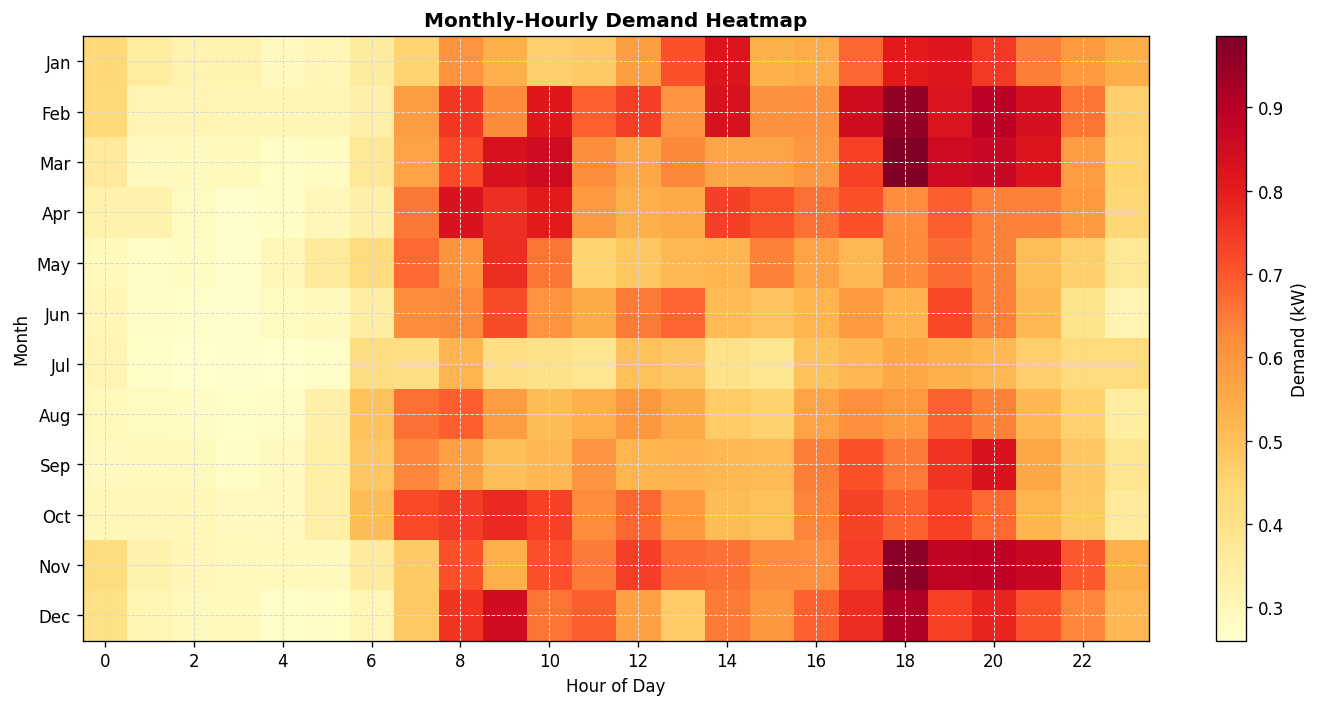

In [10]:
# Figure 4: Monthly Seasonal Analysis
# Analyze when seasonal effects are strongest across months
profiles_df["month"] = profiles_df.index.month
profiles_df["month_name"] = profiles_df.index.month_name()

# Calculate monthly average demand and seasonal amplitude
monthly_stats = profiles_df.groupby("month").agg({
    "Demand": ["mean", "std", "min", "max"]
}).round(3)
monthly_stats.columns = ['mean', 'std', 'min', 'max']
monthly_stats['amplitude'] = monthly_stats['max'] - monthly_stats['min']
monthly_stats.index = [calendar.month_abbr[m] for m in monthly_stats.index]

print("Monthly Demand Statistics:")
display(monthly_stats)

# Create monthly heatmap of hourly demand
monthly_hourly = profiles_df.groupby(["month", "hour"])["Demand"].mean().unstack()
monthly_hourly.index = [calendar.month_abbr[m] for m in monthly_hourly.index]

fig, ax = plt.subplots(figsize=(12, 6))
im = ax.imshow(monthly_hourly.values, aspect='auto', cmap='YlOrRd')
ax.set_xticks(range(0, 24, 2))
ax.set_xticklabels(range(0, 24, 2))
ax.set_yticks(range(12))
ax.set_yticklabels(monthly_hourly.index)
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Month')
ax.set_title('Monthly-Hourly Demand Heatmap')
cbar = fig.colorbar(im, ax=ax, label='Demand (kW)')

fig.tight_layout()
save_figure(fig, '06_monthly_hourly_heatmap')
plt.show()

# Save monthly statistics
monthly_stats.to_csv(TABLE_PATH / 'task6_monthly_demand_stats.csv')